## Определение возраста человека по фото для сурпермаркета

#### Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В моём распоряжении набор фотографий людей с указанием возраста.

Изучим имеющиеся данные и попытаемся построить модель компьютерного зрения для решения поставленной задачи.

Задачи:

- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитать её качество.


In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [23]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [24]:
labels.shape

(7591, 2)

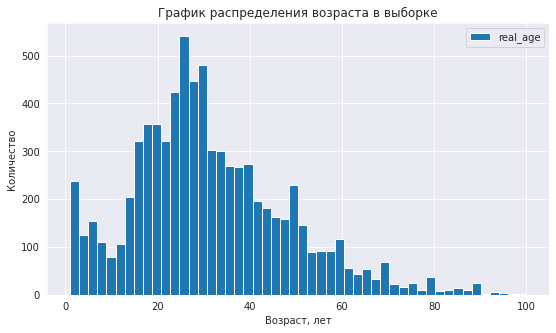

In [25]:
sns.set_style("dark")
labels.plot(kind='hist',figsize=(9,5),bins=50, grid=True)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество')
plt.show()

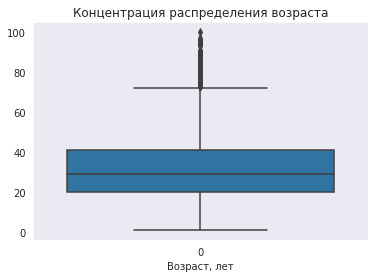

In [26]:
sns.boxplot(data=labels['real_age'])
plt.title('Концентрация распределения возраста')
plt.xlabel('Возраст, лет')
plt.show()

In [27]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


#### Теперь посмотрим на фотографии. Выведем 16 изображений

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


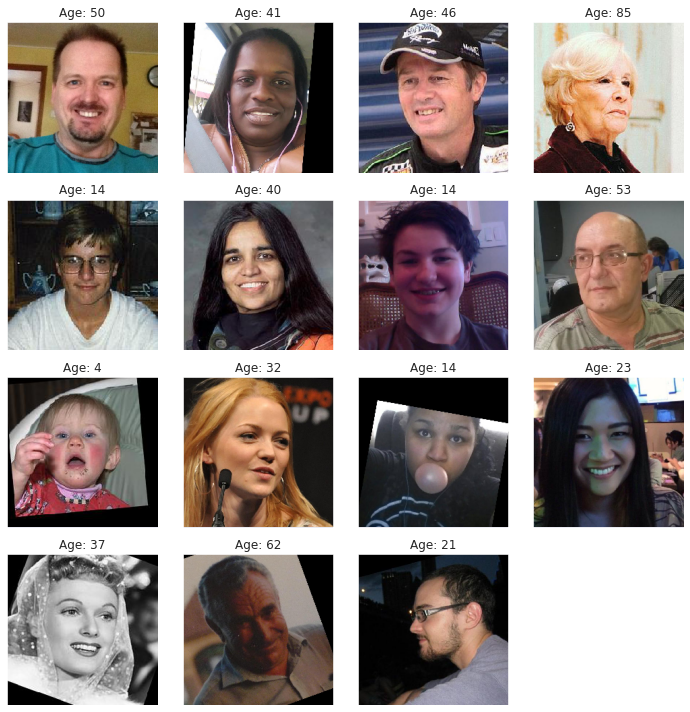

In [29]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Age: {}'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

- В датасете 7591 фотографий (небольшая выборка для оценки возраста).
- Больше всего фотографий в диапазоне от 20 лет до 41 года.
- В выборке размечены дети и старики. На возрасте 60+ довольно мало примеров, вероятно на этих возрастах модель плохо обучится и будут ошибки на предсказаниях пожилых людей. Имеется пик на возрасте до 10-и лет. Видимо присутствует довольно много фотографий маленьких детей. Это не плохо, но для магазина это не особо нужно. По сути, если эту категорию исключить из обучения, то на результат это не должно повлиять негативно.
- Распределение по возрастам выглядит нормальным, выбросов не наблюдается. Имеются пики на круглых числах. Возможно, это связано с тем, что у некоторых изображений указывался примерный возраст, то есть округлялся до десятков.
- Фотографии выглядят хорошо, без явных искажений в области лица. Чтобы улучшить обучение, думаю будет полезным, применить горизонтальный разворот изображений в обучающей выборке.
- На фотографиях присутствуют объекты, которые закрывают лицо: рука, жвачка, очки, головной убор и т.д.
- С учетом вложенных фотографий модели, будет нелегко оценивать возраст

## Обучение модели

Создадим обучающую выборку. В ней применим горизонтальный поворот. Создадим тестовую выборку и создадим функцию в которой сконструируем модель. Будем использовать ResNet50 в сочетании с GlobalAveragePoolingи выходным слоем в 1 нейрон с функцией активации ReLu, так как значения ниже нуля нам не нужны. Accuracy будем измерять метрикой MAE. Создадим функцию обучения модели. Обучим модель на 10-и эпохах:

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow


def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25,
                                   horizontal_flip=True,
                                   brightness_range=(0.8, 1.))

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer,loss='mse',metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

Результат работы модели, вывод на экран:

Train for 178 steps, validate for 60 steps

Epoch 1/10

178/178 - 88s - loss: 186.3935 - mae: 10.0931 - val_loss: 607.2261 - val_mae: 19.6456

Epoch 2/10

178/178 - 57s - loss: 92.7975 - mae: 7.2076 - val_loss: 798.5697 - val_mae: 23.3478

Epoch 3/10

178/178 - 73s - loss: 73.4263 - mae: 6.4893 - val_loss: 638.3586 - val_mae: 19.9769

Epoch 4/10

178/178 - 73s - loss: 53.5190 - mae: 5.5043 - val_loss: 140.2734 - val_mae: 8.8326

Epoch 5/10

178/178 - 65s - loss: 39.5151 - mae: 4.8328 - val_loss: 83.9599 - val_mae: 6.9072

Epoch 6/10

178/178 - 71s - loss: 32.0710 - mae: 4.3374 - val_loss: 73.6707 - val_mae: 6.4876

Epoch 7/10

178/178 - 73s - loss: 27.2739 - mae: 3.9823 - val_loss: 121.4886 - val_mae: 8.1935

Epoch 8/10

178/178 - 69s - loss: 23.8310 - mae: 3.7090 - val_loss: 80.3784 - val_mae: 6.8984

Epoch 9/10

178/178 - 60s - loss: 20.5496 - mae: 3.4902 - val_loss: 66.5224 - val_mae: 6.0162

Epoch 10/10

178/178 - 54s - loss: 17.5684 - mae: 3.1634 - val_loss: 66.5822 - val_mae: 6.0624
  
60/60 - 10s - loss: 66.5822 - mae: 6.0624

Test MAE: 6.0624